In [1]:
import itertools
import pandas as pd
import numpy as np
from random import gauss 
from prophet import Prophet
from tqdm import tqdm
from prophet.diagnostics import cross_validation, performance_metrics

c:\Users\caspe\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# Import data
item_categories = pd.read_csv('data/item_categories.csv')
items = pd.read_csv('data/items.csv')
sales_train = pd.read_csv('data/sales_train.csv', parse_dates=['date'], dayfirst=True)
sample_submission = pd.read_csv('data/sample_submission.csv')
shops = pd.read_csv('data/shops.csv')
test = pd.read_csv('data/test.csv')
prediction_csv = pd.read_csv('prophet_pred2.csv')

        date  item_cnt_day
0 2013-01-31      131479.0
1 2013-02-28      128090.0
2 2013-03-31      147142.0
3 2013-04-30      107190.0
4 2013-05-31      106970.0


<AxesSubplot: xlabel='ds'>

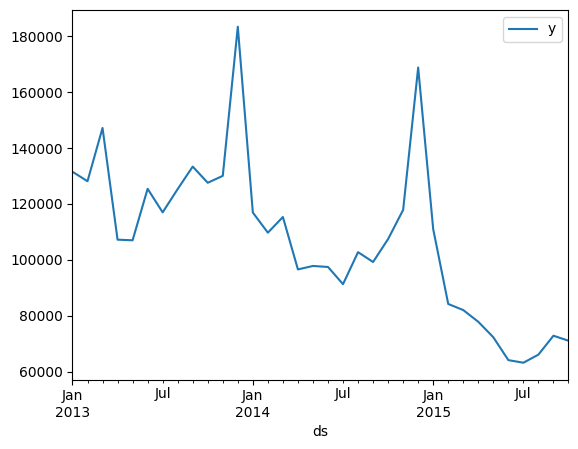

In [58]:
xdat = sales_train[['date', 'item_cnt_day']]
xdat = xdat.resample('M', on='date').sum().reset_index()
print(xdat.head())
first_valid = np.where(~np.isnan(xdat['item_cnt_day']))[0][0]
xdat = xdat.rename(columns={"date": "ds", "item_cnt_day":"y"})
xdat.set_index('ds').plot()

20:39:34 - cmdstanpy - INFO - Chain [1] start processing
20:39:35 - cmdstanpy - INFO - Chain [1] done processing


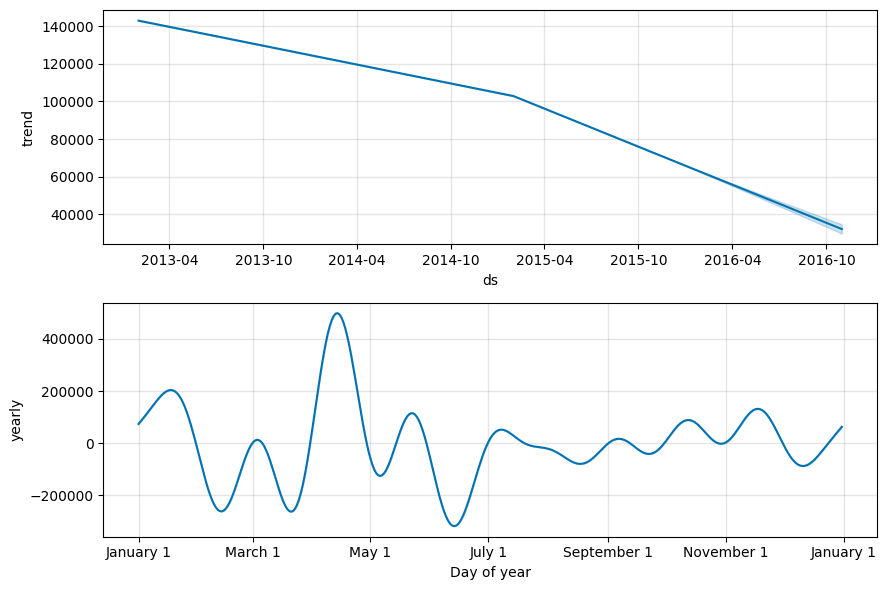

In [59]:
m = Prophet().fit(xdat)
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)
m.plot_components(forecast)
print()


20:40:42 - cmdstanpy - INFO - Chain [1] start processing
20:40:43 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_upper,yhat_lower
34,2015-11-30,82596.438906,85808.654699,79491.494202


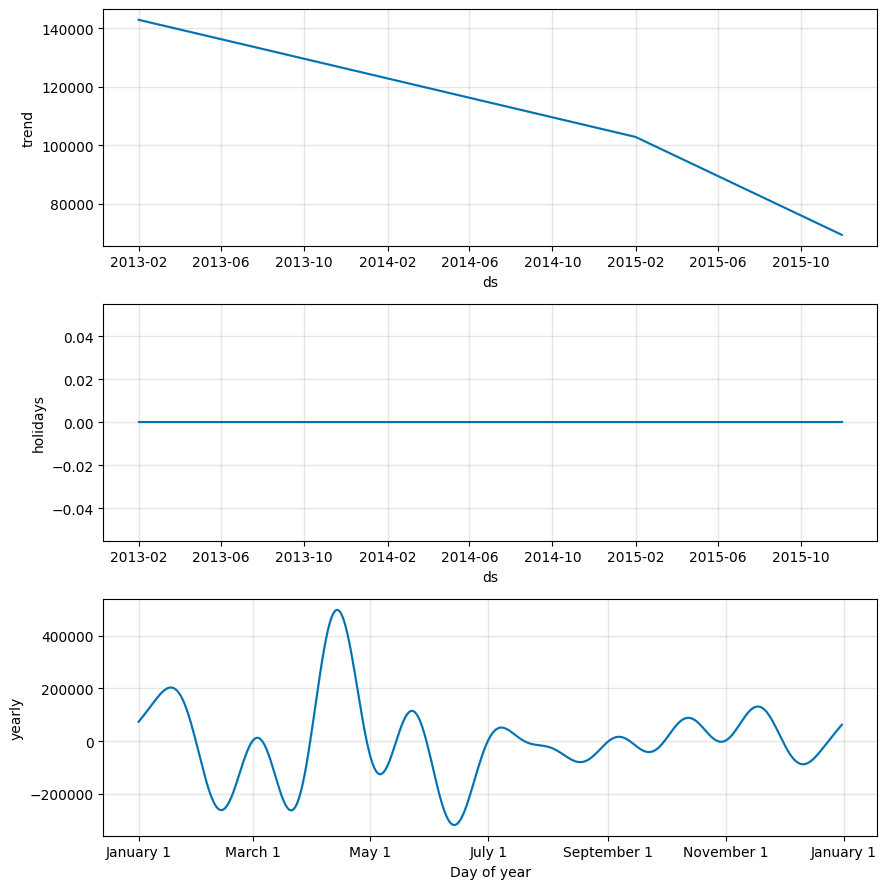

In [63]:
m = Prophet()
m.add_country_holidays(country_name="RU")
m.fit(xdat)
future = m.make_future_dataframe(periods=1, freq="M")
forecast = m.predict(future)
m.plot_components(forecast)
print()
forecast = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].loc[forecast['ds'] >= '2015-11-01']
forecast.head()

Prediction per shop

In [37]:
# xdat = sales_train.resample('M', on='date').sum()
# xdat.head()
for x in range(len(items)):
    xdat = sales_train[sales_train['item_id'] == x]
    xdat = xdat[['date', 'item_cnt_day']]
    xdat = xdat.groupby('date', as_index=False).sum()
    xdat = xdat.rename(columns={"date": "ds", "item_cnt_day":"y"})
    if len(xdat)>1:
        m = Prophet()
        m.add_country_holidays(country_name="RU")
        m.fit(xdat)
        future = m.make_future_dataframe(periods=30, freq="D")
        forecast = m.predict(future)
        forecast = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].loc[forecast['ds'] >= '2015-11-01']
        print(forecast.head())

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date,,,,,
2013-01-31,0,3417068,1183971787,8.221187e+07,131479.0
2013-02-28,108613,3111582,1076043980,7.558019e+07,128090.0
2013-03-31,242694,4016457,1220911622,8.429831e+07,147142.0
2013-04-30,282327,3164978,971345965,6.151282e+07,107190.0
2013-05-31,367036,3093999,950372988,5.727413e+07,106970.0


In [3]:
covariates = ['shop_id', 'item_id']
df = sales_train[['date', 'shop_id', 'item_id', 'item_cnt_day']]
xdat = df.groupby(['shop_id', 'item_id']).resample('M', on='date').sum()[['item_cnt_day']].reset_index()
df2 = xdat.rename(columns={'date':'ds', 'item_cnt_day':'y'})[['ds', 'y', 'shop_id', 'item_id']]
m = Prophet()
for f in covariates:
    m.add_regressor(f)
m.fit(df2)
future = m.make_future_dataframe(periods=1, freq='M')

21:11:43 - cmdstanpy - INFO - Chain [1] start processing
21:16:31 - cmdstanpy - INFO - Chain [1] done processing


In [4]:
future = future[future['ds'] >= '2015-11-1']
test['ds'] = future['ds'].values[0]
new_future = test[['ds', 'shop_id', 'item_id']]
forecast = m.predict(new_future)
prediction = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']]
prediction.index.name = 'ID'
prediction = prediction[['yhat']].rename(columns={'yhat':'item_cnt_month'})
print(len(prediction))
prediction.to_csv('prophet_pred2.csv')

214200
